### 18762 - Circuit Simulation <br/> Project 1 <br/> Lucas Godshalk

For all results, the simulation output is shown first. The second picture is from the 3rd party simulator.

In [9]:

from classes.Settings import Settings
from lib.solve import solve
from matplotlib import pyplot as plt 
from lib.parse_json import parse_json

# Part 1: RL Circuit

In [10]:
devices = parse_json('testcases/RL_circuit.json')
results = solve(devices, Settings(simulationTime=0.2, timestep=0.0001))

Circuit has 13 nodes
Total Y matrix size for circuit will be 28


#### Output Voltage Plot

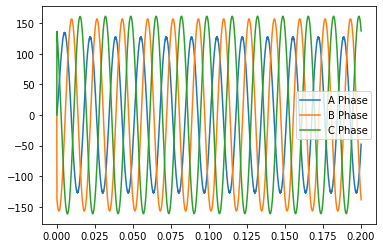

In [11]:
waveforms = [
    (results.get_node_voltage("n3_a"), "A Phase"),
    (results.get_node_voltage("n3_b"), "B Phase"),
    (results.get_node_voltage("n3_c"), "C Phase")
]

x = results.get_timesteps()

for (waveform, label) in waveforms:
    plt.plot(x, waveform, label=label)

plt.legend()
plt.show()

Here is the 3rd party output for comparison:

![image](./media/RL_circuit_simulator_plot.png)

#### Output Current Plot

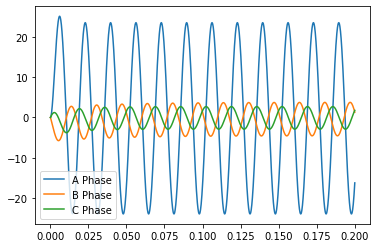

In [12]:
plt.clf()

waveforms = [
    (results.get_current_flow("n4_a", "gnd"), "A Phase"),
    (results.get_current_flow("n4_b", "gnd"), "B Phase"),
    (results.get_current_flow("n4_c", "gnd"), "C Phase")
]

x = results.get_timesteps()

for (waveform, label) in waveforms:
    plt.plot(x, waveform, label=label)

plt.legend()
plt.show()

In [ ]:
devices = parse_json('testcases/IM_circuit.json')
results = solve(devices, Settings(simulationTime=0.2, timestep=0.0001))

In [ ]:
plt.clf()

x = results.get_timesteps()

plt.plot(x, results.get_rotor_speed("im1"), label="rotor speed")

plt.legend()
plt.show()